In [111]:
import numpy as np
import pandas as pd
import tensorflow as tf
import PIL
import cv2
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

from tensorflow import keras
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, concatenate, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras.layers.core import SpatialDropout2D
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from keras import backend as K
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
np.random.seed(123)

In [112]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [113]:
BASEPATH = "../input/siim-isic-melanoma-classification"
df_train = pd.read_csv(os.path.join(BASEPATH, 'train.csv'))
df_test  = pd.read_csv(os.path.join(BASEPATH, 'test.csv'))
df_sub   = pd.read_csv(os.path.join(BASEPATH, 'sample_submission.csv'))

In [114]:
df_train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [115]:
train_path = '../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
test_path = '../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test'

In [116]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224),batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224),batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224),batch_size=10, shuffle=True)

Found 2239 images belonging to 9 classes.
Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [117]:
SEED = 123
batch_size = 10
img_height = 224
img_width =  224

In [118]:
classes=['pigmented benign keratosis',
 'melanoma',
 'vascular lesion',
 'actinic keratosis',
 'squamous cell carcinoma',
 'basal cell carcinoma',
 'seborrheic keratosis',
 'dermatofibroma',
 'nevus']

In [119]:

import pathlib
train_dir = pathlib.Path(train_path)
test_dir = pathlib.Path(test_path)

In [120]:
from PIL import Image
import os, sys

path = "../input/siim-isic-melanoma-classification/jpeg/train"
dirs = os.listdir( path )

def resize():
    for item in dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            f, e = os.path.splitext(path+item)
            imResize = im.resize((224,224), Image.ANTIALIAS)
            imResize.save(f + ' resized.jpg', 'JPEG', quality=90)

resize()

In [121]:
imgs, labels = next(train_batches)


In [122]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

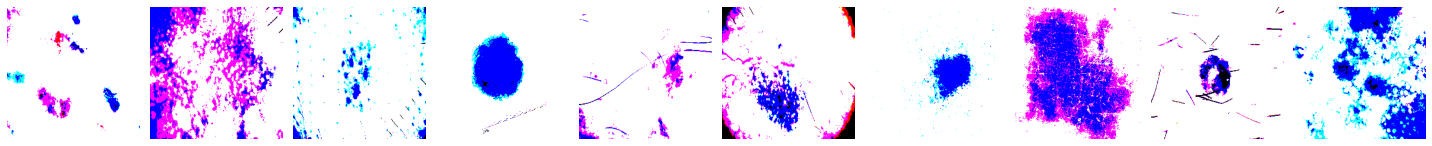

[[0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [123]:
plotImages(imgs)
print(labels)

In [124]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units= 9, activation='sigmoid')
])

In [125]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [126]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 1806345   
Total params: 1,825,737
Trainable params: 1,825,737
Non-trainable params: 0
____________________________________________

In [127]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []
    
  def on_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['accuracy'])
    
# Early stopping to stop the training if loss start to increase. It also avoids overfitting.
es = EarlyStopping(patience=3,monitor="val_loss")

reducing the steps per epoch increased the accuracy

In [128]:
from keras.callbacks import EarlyStopping
#set early stopping monitor so the model stops training when it won't improve anymore
early_stopping_monitor = EarlyStopping(patience=3)

#train model
history = model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
                    epochs=10,
                    verbose=2,
                    callbacks=[early_stopping_monitor]
                   )
                               

Epoch 1/10
224/224 - 156s - loss: 3.0567 - accuracy: 0.3703 - val_loss: 0.3421 - val_accuracy: 0.5753
Epoch 2/10
224/224 - 154s - loss: 0.2372 - accuracy: 0.6141 - val_loss: 0.1402 - val_accuracy: 0.7923
Epoch 3/10
224/224 - 155s - loss: 0.1563 - accuracy: 0.7669 - val_loss: 0.1096 - val_accuracy: 0.8821
Epoch 4/10
224/224 - 156s - loss: 0.1283 - accuracy: 0.8477 - val_loss: 0.0933 - val_accuracy: 0.9017
Epoch 5/10
224/224 - 156s - loss: 0.1110 - accuracy: 0.8607 - val_loss: 0.0972 - val_accuracy: 0.9004
Epoch 6/10
224/224 - 156s - loss: 0.0993 - accuracy: 0.8897 - val_loss: 0.0726 - val_accuracy: 0.9209
Epoch 7/10
224/224 - 156s - loss: 0.0935 - accuracy: 0.8977 - val_loss: 0.0708 - val_accuracy: 0.9285
Epoch 8/10
224/224 - 156s - loss: 0.0851 - accuracy: 0.9062 - val_loss: 0.0672 - val_accuracy: 0.9335
Epoch 9/10
224/224 - 156s - loss: 0.0820 - accuracy: 0.9053 - val_loss: 0.0639 - val_accuracy: 0.9268
Epoch 10/10
224/224 - 155s - loss: 0.0733 - accuracy: 0.9142 - val_loss: 0.0741 - 

In [129]:
label_names = sorted(train_batches.class_indices.items(), key=lambda pair:pair[1])
label_names = np.array([key.title() for key, value in label_names])
label_names

array(['Actinic Keratosis', 'Basal Cell Carcinoma', 'Dermatofibroma',
       'Melanoma', 'Nevus', 'Pigmented Benign Keratosis',
       'Seborrheic Keratosis', 'Squamous Cell Carcinoma',
       'Vascular Lesion'], dtype='<U26')

In [130]:
result_batch = model.predict(test_batches)

labels_batch = label_names[np.argmax(result_batch, axis=-1)]
labels_batch

array(['Actinic Keratosis', 'Melanoma', 'Melanoma',
       'Pigmented Benign Keratosis', 'Squamous Cell Carcinoma', 'Nevus',
       'Basal Cell Carcinoma', 'Basal Cell Carcinoma',
       'Actinic Keratosis', 'Basal Cell Carcinoma',
       'Basal Cell Carcinoma', 'Nevus', 'Basal Cell Carcinoma',
       'Actinic Keratosis', 'Nevus', 'Basal Cell Carcinoma', 'Nevus',
       'Pigmented Benign Keratosis', 'Nevus',
       'Pigmented Benign Keratosis', 'Pigmented Benign Keratosis',
       'Actinic Keratosis', 'Nevus', 'Melanoma', 'Nevus',
       'Pigmented Benign Keratosis', 'Actinic Keratosis', 'Nevus',
       'Squamous Cell Carcinoma', 'Melanoma', 'Actinic Keratosis',
       'Pigmented Benign Keratosis', 'Vascular Lesion',
       'Actinic Keratosis', 'Nevus', 'Melanoma', 'Melanoma', 'Melanoma',
       'Nevus', 'Squamous Cell Carcinoma', 'Vascular Lesion', 'Nevus',
       'Basal Cell Carcinoma', 'Nevus', 'Melanoma', 'Nevus', 'Nevus',
       'Squamous Cell Carcinoma', 'Pigmented Benign Keratos

In [131]:
test_imgs, test_labels = next(test_batches)

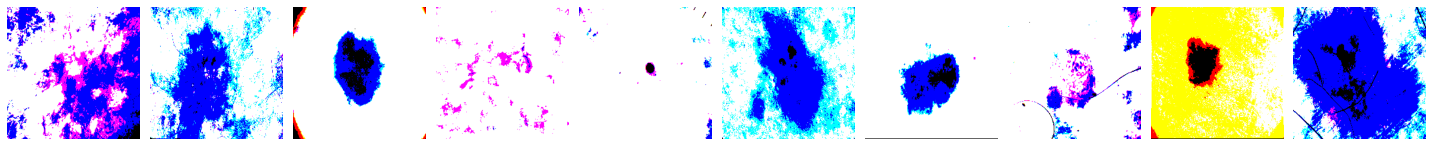

[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]]


In [132]:
plotImages(test_imgs)
print(test_labels)

not melanoma


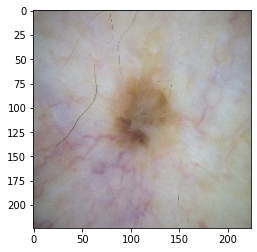

In [133]:
saved_model = model.save("melanoma_model")
from keras.preprocessing import image
img = image.load_img('../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/dermatofibroma/ISIC_0001114.jpg',target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)

from keras.models import load_model
saved_model = load_model("melanoma_model")
output = saved_model.predict(img)
if output[0][0] > output[0][1]:
    print("melanoma")
else:
    print('not melanoma')


In [134]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [135]:
np.round(predictions)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

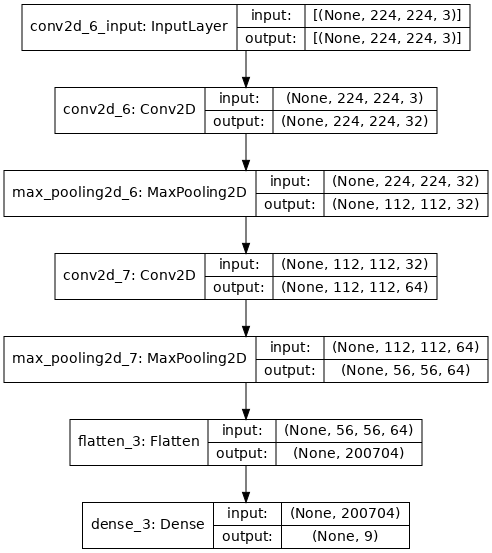

In [136]:
tf.keras.utils.plot_model(model = model , rankdir="TB", dpi=72, show_shapes=True)

In [137]:
model.evaluate(test_imgs, test_labels)

1/1 [==============================] - 0s 245ms/step - loss: 1.2149 - accuracy: 0.3000


[1.2148630619049072, 0.30000001192092896]

In [138]:
print('test data', test_imgs)
preds = np.round(model.predict(test_imgs),0) 
#to fit them into classification metrics and confusion metrics, some additional modificaitions are required
print('rounded test_labels', preds)

test data [[[[ 2.7060997e+01  2.1221001e+01  6.4320000e+01]
   [ 9.0609970e+00  5.2210007e+00  5.5320000e+01]
   [ 2.2060997e+01  1.5221001e+01  6.1320000e+01]
   ...
   [-2.3939003e+01 -2.7778999e+01  1.5320000e+01]
   [-3.3939003e+01 -3.3778999e+01  1.5320000e+01]
   [-3.1939003e+01 -3.1778999e+01  1.7320000e+01]]

  [[ 1.5060997e+01  1.3221001e+01  6.3320000e+01]
   [ 1.3060997e+01  1.0221001e+01  5.7320000e+01]
   [ 2.0060997e+01  1.4221001e+01  6.2320000e+01]
   ...
   [-2.2939003e+01 -2.6778999e+01  1.6320000e+01]
   [-2.7939003e+01 -3.0778999e+01  1.6320000e+01]
   [-3.3939003e+01 -3.3778999e+01  1.5320000e+01]]

  [[-4.9390030e+00 -3.7789993e+00  4.7320000e+01]
   [ 1.5060997e+01  9.2210007e+00  5.7320000e+01]
   [ 2.4060997e+01  1.7221001e+01  6.3320000e+01]
   ...
   [-2.1939003e+01 -2.7778999e+01  1.5320000e+01]
   [-2.5939003e+01 -3.4778999e+01  1.6320000e+01]
   [-3.5939003e+01 -3.6778999e+01  1.4320000e+01]]

  ...

  [[ 7.0609970e+00  6.2210007e+00  4.7320000e+01]
   [ 3

In [139]:
from sklearn import metrics
classes=['pigmented benign keratosis',
 'melanoma',
 'vascular lesion',
 'actinic keratosis',
 'squamous cell carcinoma',
 'basal cell carcinoma',
 'seborrheic keratosis',
 'dermatofibroma',
 'nevus']
classification_metrics = metrics.classification_report(test_labels, preds, target_names=classes )
print(classification_metrics)

                            precision    recall  f1-score   support

pigmented benign keratosis       1.00      0.50      0.67         2
                  melanoma       0.00      0.00      0.00         1
           vascular lesion       0.00      0.00      0.00         1
         actinic keratosis       0.00      0.00      0.00         2
   squamous cell carcinoma       0.33      1.00      0.50         1
      basal cell carcinoma       0.00      0.00      0.00         1
      seborrheic keratosis       0.00      0.00      0.00         0
            dermatofibroma       0.00      0.00      0.00         2
                     nevus       0.00      0.00      0.00         0

                 micro avg       0.50      0.20      0.29        10
                 macro avg       0.15      0.17      0.13        10
              weighted avg       0.23      0.20      0.18        10
               samples avg       0.20      0.20      0.20        10



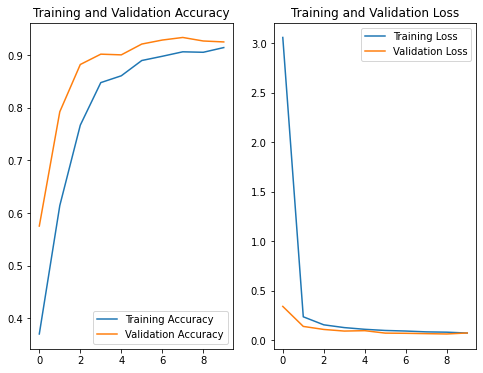

In [140]:
epochs = 10
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

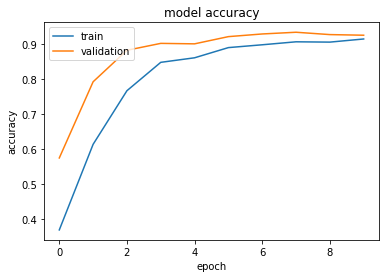

In [141]:
def plot_history(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_history(history)